# CHSH不等式の破れを確認する

この最初の実習では、量子コンピュータにおいて**量子力学的状態、特に「エンタングルメント」**が実現しているか検証してみましょう。実習を通じて量子力学の概念と量子コンピューティングの基礎を紹介していきます。

## 目次
1. {ref}`sec:probing_quantumness`
1. {ref}`sec:chsh_inequality`
1. {ref}`sec:qiskit`
  1. {ref}`subsec:qubits`
  1. {ref}`subsec:circuit`
  1. {ref}`subsec:common_gates`
  1. {ref}`subsec:circuit_visualization`
1. {ref}`sec:writing_chsh`
1. {ref}`sec:using_ibmq`
1. {ref}`sec:analysis`

$\newcommand{ket}[1]{|#1\rangle}$

(sec:probing_quantumness)=
## 本当に量子コンピュータなのか？

このワークブックの主旨が量子コンピュータ（QC）を使おう、ということですが、QCなんて数年前までSFの世界の存在でした。それが今やクラウドの計算リソースとして使えるというわけですが、ではそもそも私たちがこれから使おうとしている機械は本当にQCなのでしょうか。どうしたらそれが調べられるでしょうか。

QCの基本的な仕組みは、**「何らの物理的な系（超電導共振器や冷却原子など）をうまく操作して、求める計算の結果がその系の量子状態に表現されるようにする」**ということです。つまり、量子状態が長く保たれてかつ思うように操作できる対象と、「計算」という実体のなさそうなものを具体的な「量子操作」に対応させるアルゴリズムの両方があって初めてQCが成り立ちます。アルゴリズムの部分はこのワークブックを通じてちょっとずつ紹介していくので、今回は「量子状態が保たれ、それを操作できる」ということを確認してみましょう。

(sec:chsh_inequality)=
## CHSH不等式とは

CHSH不等式やその根本であるBell不等式の意義については、{doc}`quantum_basics`を参照してください。かいつまんで言うと、CHSH不等式とは「二体系の特定の観測量について、エンタングルメントなど量子力学固有の現象がなければ保たれる不等式」です。やや回りくどいロジックですが、つまりQC（だと考えられる機械）で測ったこの観測量の値がCHSH不等式を破っていれば、その機械は実際に量子現象を利用していると言えることになります。

通常このような実験を行うには高度なセットアップ（レーザーと非線形結晶、冷却原子など）が必要ですが、クラウドQCではブラウザ一つしか要りません。このワークブックではJupyter NotebookでPythonのプログラムを書き、[IBM Quantum Experience](https://quantum-computing.ibm.com/)を通じて[IBM Q System One](https://www.ibm.com/quantum-computing/systems/)を利用します。

(sec:qiskit)=
## Qiskitの基本構造

IBM Q System OneのQCで量子計算を実行するには、IBMの提供する[Qiskit](https://qiskit.org/)というPythonライブラリを利用します。Qiskitの基本的な使い方は

1. 空っぽの量子回路を定義する。
1. 回路に量子計算の操作（ゲート）を足していく。
1. 回路を実行して計算結果を得る。ここでは二通りのオプションがあり、
  - 回路をQCの実機に送り、実行させる。
  - 回路をシミュレートする。
1. 計算結果を解析する。

です。以下でこの流れを一通り、重要な概念の説明を混ぜながら実行してみましょう。

(subsec:qubits)=
### 量子ビット

　**量子ビット**（qubit=キュビット）とは量子コンピュータの基本構成要素のことで、量子情報の入れ物の最小単位です。量子ビットや量子レジスタ（量子ビットを並べたもの）は量子コンピュータ中で常に一つの「状態」にあります。

　量子レジスタの状態を物理学の習わしに従ってしばしば「ケット」という$\ket{\psi}$のような記号で表しますが、これ自体はただの記号なので特に意味はありません。別に「枠」なしで$\psi$と書いても、絵文字を使って🔱と書いても、何でも構いません。

　重要なのは各量子ビットに対して2つの**基底状態**が定義できることで、量子計算の習わしではそれらを$\ket{0}$と$\ket{1}$で表し、「計算基底」とも呼びます[^basis]。そして、量子ビットの任意の状態は、2つの複素数$\alpha, \beta$を使って
$$
\alpha \ket{0} + \beta \ket{1}
$$
と2つの基底の「重ね合わせ」で表せます。ここで$\alpha, \beta$を確率振幅や単に**振幅**（amplitude）と呼ぶこともあります。繰り返しですが別に表記法自体に深い意味はなく、例えば同じ状態を$[\alpha, \beta]$と書いてもいいわけです[^complexarray]。

　量子ビットの任意の状態が2つの複素数で表せるということは、逆に言えば一つの量子ビットには2つの複素数に相当する情報を記録できるということになります。ただこれには少し注釈があって、量子力学の決まりごとから、$\alpha$と$\beta$は
$$
|\alpha|^2 + |\beta|^2 = 1
$$
という関係を満たさなければならず、かつ全体の位相（global phase）は意味を持たない、つまり
$$
\alpha \ket{0} + \beta \ket{1} \sim e^{i\theta} (\alpha \ket{0} + \beta \ket{1})
$$
（ここで $\sim$ は「同じ量子状態を表す」という意味）という制約があります。

　複素数1つは実数2つで書けるので$\alpha$と$\beta$をあわせて実数4つ分の情報が入っているようですが、2つの拘束条件があるため、実際の自由度は$4 - 2 = 2$個です。自由度の数をあらわにして量子ビットの状態を記述するときは、
$$
e^{i\phi/2}\cos\frac{\theta}{2}\ket{0} + e^{-i\phi/2}\sin\frac{\theta}{2}\ket{1}
$$
と書いたりもします。この表記法をブロッホ球表現と呼ぶこともあります（詳細は{doc}`quantum_basics`にて）。

　面白くなるのは量子ビットが複数ある場合です。例えば量子ビット2つなら、それぞれに$\ket{0}, \ket{1}$の計算基底があるので、任意の状態は
$$
\alpha \ket{0}\ket{0} + \beta \ket{0}\ket{1} + \gamma \ket{1}\ket{0} + \delta \ket{1}\ket{1}
$$
と4つの複素数を使った重ね合わせになります。2つの量子ビットの基底を並べた$\ket{0}\ket{0}$のような状態が、このレジスタの計算基底ということになります。$\ket{00}$と略したりもします。

　上で登場した量子力学の決まりごとはこの場合
$$
|\alpha|^2 + |\beta|^2 + |\gamma|^2 + |\delta|^2 = 1
$$
と
$$
\alpha \ket{00} + \beta \ket{01} + \gamma \ket{10} + \delta \ket{11} \sim e^{i\theta} (\alpha \ket{00} + \beta \ket{01} + \gamma \ket{10} + \delta \ket{11})
$$
となります。量子ビットがいくつあっても拘束条件は2つだけです。

　つまり、量子ビット$n$個レジスタでは、基底の数が$2^n$個で、それぞれに複素数の振幅がかかるので、実数$2 \times 2^n - 2$個分の情報が記録できることになります。これが量子計算に関して「指数関数的」という表現がよく用いられる所以です。

　量子レジスタの計算基底状態の表記法としては、上に書いたようにケットを$n$個並べたり$n$個の0/1を一つのケットの中に並べたりする方法がありますが、さらにコンパクトなのが、0/1の並び（ビット列）を二進数とみなして、対応する（十進数の）数字で表現する方法です。例えば4量子ビットのレジスタで状態$\ket{0000}$と$\ket{1111}$はそれぞれ$\ket{0}$と$\ket{15}$と書けます。
 
　ただし、ここで注意すべきなのは、左右端のどちらが「1の位」なのか事前に約束しないといけないことです。$\ket{0100}$を$\ket{4}$（右端が1の位）とするか$\ket{2}$（左端が1の位）とするかは約束次第です。このワークブックでは、Qiskitでの定義に従って、右端を1の位とします。同時に、レジスタの最初の量子ビットが1の位に対応するようにしたいので、ケットや0/1を並べて計算基底を表現するときは、右から順にレジスタの量子ビットを並べていくことにします。

　Qiskitには量子レジスタオブジェクトがあり、
```python
from qiskit import QuantumRegister
register = QuantumRegister(4, 'myregister')
```
のように量子ビット数（この場合4）と名前（`'myregister'`）を指定して初期化します。初期状態では、量子ビットはすべて$\ket{0}$状態にあります。レジスタオブジェクトはこのままではあまり使い道がなく、基本的には次に紹介する量子回路の一部として利用します。

(subsec:circuit)=
### ゲート、回路、測定

　量子計算とは、端的に言えば、量子レジスタに特定の状態を生成し、その振幅を利用することと言えます。

　とは言っても、いきなり「えいや」と好きな量子状態を作れるわけではなく、パターンの決まった単純操作（$\ket{0}$と$\ket{1}$の振幅を入れ替える、ブロッホ球表現での位相角度$\phi$を増減させる、など）を順番に組み合わせて複雑な状態を作っていきます。この単純操作のオペレーションのことを一般に量子**ゲート**といい、ゲートの種類や順番を指定したプログラムに相当するものを量子**回路**と呼びます。

　Qiskitでは、量子回路を`QuantumCircuit`オブジェクトで表します。
```python
from qiskit import QuantumCircuit, QuantumRegister
register = QuantumRegister(4, 'myregister')
circuit = QuantumCircuit(register)
```
という具合です。

　作られた量子回路は、量子ビットの数は決まっているもののゲートが一つもない「空っぽ」の状態なので、そこにゲートをかけていきます。例えば下で説明するアダマールゲートをレジスタの2個目の量子ビットに作用させるには
```python
circuit.h(register[1])
```
とします。

　上で「振幅を利用する」という曖昧な表現をしましたが、それはいろいろな利用の仕方があるからです。しかし、どんな方法であっても、必ず量子レジスタの**測定**という操作を行います。量子コンピュータから何かしらの情報を得るための唯一の方法が測定です。
 
　測定は量子レジスタの状態を「覗き見る」ような操作ですが、一回の測定操作で具体的に起きることは、各量子ビットに対して0もしくは1という値が得られるというだけです。つまり、量子状態が$2^n$個の計算基底の複雑な重ね合わせであったとしても、測定をすると一つの計算基底に対応するビット列が出てくるだけということになります。しかも、一度測定してしまった量子ビットはもう状態を変えてしまっていて、複雑な重ね合わせは失われてしまいます。

　ではこの「一つの計算基底」がどの基底なのかというと、実は特殊な場合を除いて決まっていません。全く同じ回路を何度も実行して測定を繰り返すと、その都度ランダムにビット列が決まります。ただし、このランダムさには法則があって、**特定のビット列が得られる確率は、対応する計算基底の振幅の絶対値自乗**となっています。つまり、$n$長レジスタの状態$\sum_{j=0}^{2^n-1} c_j \ket{j}$があるとき、測定でビット列$k$が得られる確率は$|c_k|^2$です。
 
　したがって、回路の実行と測定を何度も繰り返して、それぞれのビット列が現れる頻度を記録すれば、だんだん$|c_j|^2$の値がわかっていき、レジスタがどんな量子状態にあるのか見えてきます。しかしわかるのは$c_j$の絶対値だけで、複素位相については知る術なしです。どうもすっきりしませんが、これが量子コンピュータから情報を得る方法です。

　逆に、指数関数的な内部の情報量をうまく使って計算を行いつつ、測定という限定的な方法でも答えが読み出せるように工夫するのが、量子アルゴリズム設計の真髄ということになります。例えば理想的には、何か計算の答えが整数$k$であり、それを計算する回路の終状態が単純に$\ket{k}$となるようであれば、一度の測定で答えがわかる（上でいった特殊な場合に相当）わけです。単純に$\ket{k}$でなくても、重ね合わせ$\sum_{j=0}^{2^n-1} c_j \ket{j}$において$|c_k| \gg |c_{j \neq k}|$を実現できれば、数回の測定で答えが高確率でわかります。{doc}`shor`で紹介する位相推定アルゴリズムはその好例です。

(subsec:common_gates)=
### よく使うゲート

　IBM Q System Oneのような超電導振動子を利用した量子コンピュータでは、実際に使用できるゲートは量子ビット1つにかかるものと2つにかかるものに限定されます。しかし、それらを十分な数組み合わせれば、$n$量子ビットレジスタにおいてどのような状態も実現できることが、数学的に証明できます。

　1量子ビットの操作でよく使われるゲートには、以下のようなものがあります。

- $X$: $\ket{0}$と$\ket{1}$の振幅を交換する
- $Z$: $\ket{1}$の振幅を$-1$倍する
- $H$（アダマールゲート）: 計算基底それぞれに対して、以下の変形をする。
$$
H\ket{0} = \frac{1}{\sqrt{2}} (\ket{0} + \ket{1}) \\
H\ket{1} = \frac{1}{\sqrt{2}} (\ket{0} - \ket{1})
$$
（「量子状態にゲートを作用させる」ことをケットの記法で書くときは、ゲートに対応する記号をケットに左からかけます。）<br/>
例えば状態$\ket{\psi} = \alpha\ket{0} + \beta\ket{1}$に対しては、
$$
\begin{align}
H\ket{\psi} & = \alpha \frac{1}{\sqrt{2}} (\ket{0} + \ket{1}) + \beta \frac{1}{\sqrt{2}} (\ket{0} - \ket{1}) \\
            & = \frac{1}{\sqrt{2}} (\alpha + \beta) \ket{0} + \frac{1}{\sqrt{2}} (\alpha - \beta) \ket{1}
\end{align}
$$
となります。
- $R_{y}$: パラメータ$\theta$を取り、計算基底それぞれに対して、以下の変形をする。
$$
R_{y}(\theta)\ket{0} = \cos\frac{\theta}{2}\ket{0} - \sin\frac{\theta}{2}\ket{1} \\
R_{y}(\theta)\ket{1} = \sin\frac{\theta}{2}\ket{0} + \cos\frac{\theta}{2}\ket{1}
$$
- $R_{z}$: パラメータ$\phi$を取り、計算基底それぞれに対して、以下の変形をする。
$$
R_{z}(\phi)\ket{0} = e^{-i\phi/2}\ket{0} \\
R_{z}(\phi)\ket{1} = e^{i\phi/2}\ket{1}
$$

　それでは、2量子ビットレジスタの第1ビットに$H, R_y, X$の順にゲートをかけて、最後に測定をする回路をQiskitで書いてみましょう。

In [14]:
from qiskit import QuantumCircuit
import numpy as np

circuit = QuantumCircuit(2) # レジスタを介さずビット数を指定して回路を作成することもできます
circuit.h(0) # その場合、ゲートにはregister[0]ではなく直接量子ビットの番号を指定します
circuit.ry(-np.pi / 2., 0) #　θ = -π/2
circuit.x(0)
circuit.measure_all()

print('This circuit has', circuit.num_qubits, 'qubits and', circuit.size(), 'operations')

This circuit has 2 qubits and 5 operations


　最後のプリント文で、ゲートが3つなのにも関わらず"5 operations"と出てくるのは、各量子ビットの測定も一つのオペレーションとして数えられるからです。

　量子計算に慣れる目的で、この$H, R_y(-\pi/2), X$という順の操作で第1ビットに何が起こるかを辿ってみましょう。初期状態は$\ket{0}$で、ケット記法では操作は左からかけていくので、$X R_y(-\pi/2) H \ket{0}$を計算することになります。
$$
\begin{align}
X R_y\left(\frac{\pi}{2}\right) H \ket{0} & = X R_y\left(-\frac{\pi}{2}\right) \frac{1}{\sqrt{2}}(\ket{0} + \ket{1}) \\
& = \frac{1}{\sqrt{2}} X \left[\left(\cos\left(-\frac{\pi}{4}\right)\ket{0} - \sin\left(-\frac{\pi}{4}\right)\ket{1}\right) + \left(\sin\left(-\frac{\pi}{4}\right)\ket{0} + \cos\left(-\frac{\pi}{4}\right)\ket{1}\right)\right] \\
& = \frac{1}{\sqrt{2}} X \frac{1}{\sqrt{2}} \left[\left(\ket{0} + \ket{1}\right) + \left(-\ket{0} + \ket{1}\right)\right] \\
& = \frac{1}{2} X \ket{1} \\
& = \ket{0}
\end{align}
$$
なので、結局$\ket{0}$状態に戻る操作でした。

　2量子ビットの操作は、量子ビットの超電導素子での実装の都合上、全て一つの方式で行われます。この方式は制御ゲート（controlled gates）と呼ばれ、2つのビットのうち片方を制御（control）、もう片方を標的（target）として、制御ビットが1の時だけ標的ビットに何らかの操作がかかるというものです。例として、ある1ビットゲート$U$を制御ゲート化した$C^i_j[U]$を考えます。ここで$i$が制御、$j$が標的ビットとします。2ビットレジスタの第2ビットを制御、第1ビットを標的とすると（並べて書くときは左が第2で右が第1です）
$$
\begin{align}
C^1_0[U](\ket{0}\ket{0}) & = \ket{0}\ket{0} \\
C^1_0[U](\ket{0}\ket{1}) & = \ket{0}\ket{1} \\
C^1_0[U](\ket{1}\ket{0}) & = \ket{1}U\ket{0} \\
C^1_0[U](\ket{1}\ket{1}) & = \ket{1}U\ket{1}
\end{align}
$$
です。

　上で紹介した頻出する1ビットゲート$X, Z, H, R_y, R_z$のうち、$H$以外は制御ゲート化バージョンもよく使われます。

　Qiskitで2ビットレジスタに制御ゲートを用い、計算基底$\ket{0}, \ket{1}, \ket{2}, \ket{3}$の振幅の絶対値自乗が$1:2:3:4$の比になるような状態を作ってみましょう。さらに$C^0_1[Z]$ゲートを使って$\ket{3}$だけ振幅の符号が他と異なるようにします。

In [15]:
theta1 = np.arctan(np.sqrt(7. / 3.))
theta2 = np.arctan(np.sqrt(2.))
theta3 = np.arctan(np.sqrt(4. / 3))

circuit = QuantumCircuit(2)
circuit.ry(-theta1, 1)
circuit.ry(-theta2, 0)
circuit.cry(-(theta3 - theta2), 1, 0) # C[Ry]　1が制御で0が標的
circuit.cz(0, 1) # C[Z] 0が制御で1が標的（実はC[Z]ではどちらが制御でも結果は同じ）
circuit.measure_all()

　やや複雑ですが、また計算を追って見ましょう。まず角度$\theta_1, \theta_2, \theta_3$は定義から以下の関係を満たします。
$$
\begin{align}
R_y(-\theta_1)\ket{0} & = \sqrt{\frac{3}{10}} \ket{0} + \sqrt{\frac{7}{10}} \ket{1} \\
R_y(-\theta_2)\ket{0} & = \sqrt{\frac{1}{3}} \ket{0} + \sqrt{\frac{2}{3}} \ket{1} \\
R_y(-(\theta_3 - \theta_2))R_y(-\theta_2)\ket{0} & = R_y(-\theta_3)\ket{0} = \sqrt{\frac{3}{7}} \ket{0} + \sqrt{\frac{4}{7}} \ket{1}.
\end{align}
$$
したがって、
$$
\begin{align}
C^1_0[R_y(-(\theta_3 - \theta_2))]R_y(-\theta_1)\ket{0}R_y(-\theta_2)\ket{0} & = C^1_0[R_y(-(\theta_3 - \theta_2))]\left(\sqrt{\frac{3}{10}} \ket{0} + \sqrt{\frac{7}{10}} \ket{1}\right) R_y(-\theta_2)\ket{0}\\
& = \sqrt{\frac{3}{10}} \ket{0} R_y(-\theta_2)\ket{0} + \sqrt{\frac{7}{10}} \ket{1} R_y(-\theta_3)\ket{0} \\
& = \sqrt{\frac{3}{10}} \ket{0} \left(\sqrt{\frac{1}{3}} \ket{0} + \sqrt{\frac{2}{3}} \ket{1}\right) + \sqrt{\frac{7}{10}} \ket{1} \left(\sqrt{\frac{3}{7}} \ket{0} + \sqrt{\frac{4}{7}} \ket{1}\right) \\
& = \sqrt{\frac{1}{10}} \ket{00} + \sqrt{\frac{2}{10}} \ket{01} + \sqrt{\frac{3}{10}} \ket{10} + \sqrt{\frac{4}{10}} \ket{11} 
\end{align}
$$
最後に$C[Z]$をかけると、$\ket{11}$だけ符号が反転します。

(subsec:circuit_visualization)=
### 回路図の書き方と読み方

　量子回路を可視化する方法として、「回路図」の標準的な描き方が決まっています。Qiskitでは`QuantumCircuit`オブジェクトの`draw()`というメソッドを使って自動描画できます。

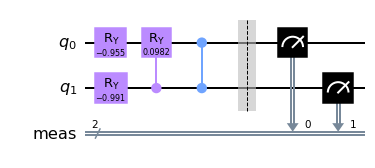

In [16]:
circuit.draw('mpl')

　ここで`draw()`の引数`'mpl'`はmatplotlibライブラリを使ってカラーで描くことを指定しています。実行環境によっては対応していないこともあるので、その場合は引数なしの`draw()`を使います。結果は`mpl`の場合に比べて見劣りしますが、内容は同じです。

In [17]:
circuit.draw()

┌──────────────┐┌──────────────┐    ░ ┌─┐   
   q_0: ┤ RY(-0.95532) ├┤ RY(0.098245) ├─■──░─┤M├───
        ├──────────────┤└──────┬───────┘ │  ░ └╥┘┌─┐
   q_1: ┤ RY(-0.99116) ├───────■─────────■──░──╫─┤M├
        └──────────────┘                    ░  ║ └╥┘
meas: 2/═══════════════════════════════════════╩══╩═
                                               0  1

　回路図は左から右に読んでいきます。水平の2本の実線が上からそれぞれ第1、第2量子ビットに対応し、その上にかぶさっている四角がゲート、最後にある矢印が下に伸びている箱が測定を表します。1ビットゲートから伸びている先端の丸い縦線は制御を表します。一番下の二重線は「古典レジスタ」に対応し、測定結果の0/1が記録される部分です。

(sec:writing_chsh)=
## CHSH不等式を計算する回路を書く

　それではいよいよ本題に入りましょう。

(sec:using_ibmq)=
## IBMQを使う

(sec:analysis)=
## 量子測定結果の解析

[^basis]: ここで言う「基底」は線形代数での意味（basis）で、「線形空間中の任意のベクトルを要素の線形和で表せる最小の集合」です。基底となる量子状態だから「基底状態」と呼びます。化学や量子力学で言うところのエネルギーの最も低い状態「基底状態」（ground state）とは関係ありません。
[^complexarray]: 実際に量子計算のシミュレーションをコンピュータ上で行う時などは、量子レジスタの状態を複素数の配列で表すので、この表記の方がよく対応します。